In [1]:
from __future__ import print_function
import numpy as np
import scipy.io as sio
import pandas as pd
from sklearn.metrics import mean_squared_error

np.random.seed(1337)  # for reproducibility

# from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
# input image dimensions
img_rows, img_cols = 128, 128
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

# training data, shuffled and split between train and test sets
WB=sio.loadmat('sandstone_data.mat')['Data']
Y_data = sio.loadmat('sandstone_data.mat')['L']
# Y_data = (Y_data-min(Y_data))/(max(Y_data)-min(Y_data))
X_data = np.reshape(WB,(768,1,img_rows,img_cols))


# Add 380 generated images using VAE+ST from Ruijin's code
WB_gen = np.array(sio.loadmat('generate_sandstone_data_noshuffle.mat')['sample_total'])
Y_gen = np.array(sio.loadmat('generate_sandstone_data_noshuffle.mat')['Data_all'])[:,-1]
X_gen = np.transpose(np.reshape(WB_gen,(380,1,img_rows,img_cols)),[0,1,3,2])

# test data
WB1 = sio.loadmat('test_sandstone_data.mat')['Data']
X_test = np.reshape(WB1, (240, 1, img_rows, img_cols))
Y_test = sio.loadmat('test_sandstone_data.mat')['L']
# Y_test = (Y_test-min(Y_test))/(max(Y_test) - min(Y_test))

index = np.random.permutation(len(X_gen))
X_gen = X_gen[index]
Y_gen = Y_gen[index]

#Define Traing data and validation data
X_total = np.concatenate((X_data, X_gen, X_test))
Y_total = np.concatenate((Y_data.reshape(-1), Y_gen.reshape(-1),Y_test.reshape(-1)),axis=0)
Y_total = (Y_total-min(Y_total))/(max(Y_total)-min(Y_total))

X_train = X_total[:1000]                  
Y_train = Y_total[:1000]

X_val = X_total[1000:-240]
Y_val = Y_total[1000:-240]

X_test = X_total[-240:]                  
Y_test = Y_total[-240:]


if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_val = X_val.reshape(X_val.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validate samples')
print(X_test.shape[0], 'test samples')

X_train shape: (1000, 128, 128, 1)
1000 train samples
148 validate samples
240 test samples


In [3]:
# CNN follow vgg16 structure...
# Because the pictrue size is 128, the feture number might need to reduce....

model = Sequential()

#block 1
model.add(Convolution2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
#block 2
model.add(Convolution2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
#block 3
model.add(Convolution2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
#block 4
model.add(Convolution2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
#block 5
model.add(Convolution2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

"""
model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
# model.add(Dropout(0.25))
"""

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
activation_3 (Activation)    (None, 64, 64, 64)        0         
__________

In [8]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')

model.fit(X_train, Y_train, batch_size=40, epochs=10, verbose=1, validation_data=(X_val, Y_val),
         callbacks=[early_stop])

Train on 1000 samples, validate on 148 samples
Epoch 1/100
1000/1000 [==============================] - 291s - loss: 3.7718e-04 - mean_squared_error: 3.7718e-04 - val_loss: 2.5007e-04 - val_mean_squared_error: 2.5007e-04
Epoch 2/100
1000/1000 [==============================] - 273s - loss: 3.5173e-04 - mean_squared_error: 3.5173e-04 - val_loss: 4.2015e-04 - val_mean_squared_error: 4.2015e-04
Epoch 3/100
1000/1000 [==============================] - 269s - loss: 3.7180e-04 - mean_squared_error: 3.7180e-04 - val_loss: 4.8039e-04 - val_mean_squared_error: 4.8039e-04
Epoch 4/100
1000/1000 [==============================] - 268s - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 6.7124e-04 - val_mean_squared_error: 6.7124e-04
Epoch 5/100
1000/1000 [==============================] - 271s - loss: 4.6890e-04 - mean_squared_error: 4.6890e-04 - val_loss: 2.8496e-04 - val_mean_squared_error: 2.8496e-04
Epoch 6/100
1000/1000 [==============================] - 148s - loss: 3.1146e-04 - mean_squ

KeyboardInterrupt: 

training mse: 0.000398148314442
testing mse: 0.00134186184521


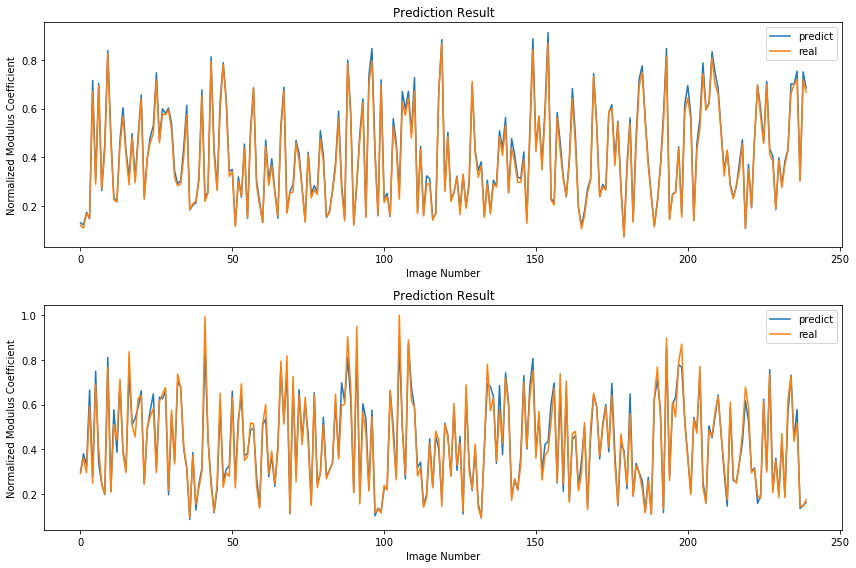

In [9]:
x=[]
num = 240
for i in range(num):
    x.append(i)

fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(2,1,1)

train_pred=model.predict(X_train)
print('training mse:', mean_squared_error(Y_train, train_pred))

ax1.plot(x,train_pred[0:num], label='predict')
ax1.plot(x,Y_train[0:num],label='real')
plt.legend()
ax1.set_title('Prediction Result')
ax1.set_xlabel('Image Number')
ax1.set_ylabel('Normalized Modulus Coefficient')


ax2=fig.add_subplot(2,1,2)

test_pred=model.predict(X_test)
print('testing mse:', mean_squared_error(Y_test, test_pred))

ax2.plot(x,test_pred[0:num], label='predict')
ax2.plot(x,Y_test[0:num],label='real')
plt.legend()
ax2.set_title('Prediction Result')
ax2.set_xlabel('Image Number')
ax2.set_ylabel('Normalized Modulus Coefficient')

plt.tight_layout()

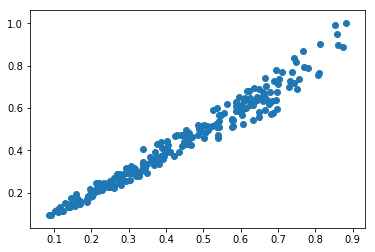

In [10]:
plt.scatter(test_pred, Y_test)